# Return Prediction for View and Uncertainty Matrix

In [64]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import yfinance as yf

# Function to preprocess data
def preprocess_data(df, shift=100):
    df['Date'] = pd.to_datetime(df.index)
    df.set_index('Date', inplace=True)
    df['Future_Return'] = df['Adj Close'].shift(-shift) / df['Adj Close'] - 1
    df = df.dropna(subset=['Future_Return'])
    df.loc[:, 'SMA_5'] = df['Adj Close'].rolling(window=5).mean()
    df = df.dropna()
    features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'SMA_5']
    X = df[features]
    y = df['Future_Return']
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)
    return X, y

# Function to train models and perform bootstrapping
def train_and_predict(X_train, y_train, X_test, n_iterations=100):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=10, n_estimators=100)
    }
    predictions = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        preds = np.zeros((n_iterations, X_test.shape[0]))
        for i in range(n_iterations):
            preds[i] = model.predict(X_test)
        predictions[model_name] = preds.mean(axis=0)

    return predictions

# Function to preprocess data and split into training and testing sets
def split_data(company_data, shift=100):
    X, y = preprocess_data(company_data)
    train_size = int(len(X) - shift)
    return (X[:train_size], X[train_size:], y[:train_size], y[train_size:])

def get_views(tickers, start_date="2022-12-31", end_date="2024-03-31", models=['Linear Regression', 'Random Forest', 'XGBoost']):
    # Download historical data for each stock
    companies_data = []
    for ticker in tickers:
        companies_data.append(yf.download(ticker, start=start_date, end=end_date))

    # Preprocess data and split into training and testing sets
    data_splits = []
    for df in companies_data:
        data_splits.append(split_data(df))

    # Initialize matrices to store results
    n_companies = len(tickers)
    n_models = len(models)
    returns_dict = {model: [0]*n_companies for model in models}
    confidence_intervals_dict = {model: [[0, 0] for _ in range(n_companies)] for model in models}  # lower and upper bounds
    uncertainty_dict = {model: [0]*n_companies for model in models}

    # Train models and calculate predictions
    predicted_returns = []
    for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
        predictions = train_and_predict(X_train, y_train, X_test)
        uncertainties = train_and_predict(X_train, y_train, X_test)
        predicted_returns.append(predictions)

        for _, model in enumerate(models):
            # Store predictions
            returns_dict[model][i] = predictions[model].mean()

            # Store confidence intervals (95% CI)
            confidence_intervals_dict[model][i][0] = predictions[model].mean() - 1.96 * uncertainties[model].mean()
            confidence_intervals_dict[model][i][1] = predictions[model].mean() + 1.96 * uncertainties[model].mean()

            # # Calculate uncertainty as the width of the confidence interval
            uncertainty_dict[model][i] = confidence_intervals_dict[model][i][1] - confidence_intervals_dict[model][i][0]
    return returns_dict, confidence_intervals_dict, uncertainty_dict

In [65]:
# Download historical data for each stock
def combined_data(tickers, start_date="2022-12-31", end_date="2024-03-31", risk_free_rate=0.02, save=False, output_dir="./"):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start_date, end=end_date)[['Open', 'Adj Close']]

    # Combine the data into a single DataFrame
    df_combined = pd.DataFrame()
    for ticker in tickers:
        df_temp = data[ticker].copy()
        df_temp.columns = [f'{ticker}_Open', f'{ticker}_Close']
        df_combined = pd.merge(df_combined, df_temp, left_index=True, right_index=True, how='outer')

    # Add a sample risk-free rate (e.g., 1% per year, constant)
    df_combined['RiskFreeRate'] = risk_free_rate

    # Save the combined DataFrame to a CSV file
    if save:
        df_combined.to_csv(f'{output_dir}combined_stock_data.csv')

    # Display the combined DataFrame
    print(df_combined.head())
    return df_combined

In [66]:
def get_returns(tickers, df_combined):
    assets = []
    for ticker in tickers:
        assets.append(f"{ticker}_Close")
    for asset in assets:
        df_combined[f'{asset}_Return'] = df_combined[asset].pct_change()

    # Drop NaN values
    df_combined.dropna(inplace=True)

    # Select return columns
    return_columns = [f'{asset}_Return' for asset in assets]
    returns = df_combined[return_columns]

    return returns

In [80]:
start_date="2022-12-31"
end_date="2024-03-31"
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "IBM", "TSLA", "NVDA", "INTC", "ADBE", "CSCO"]

In [81]:
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)[['Open', 'Adj Close']]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [82]:
data["IBM"]

Open   Adj Close
Date                              
2023-01-03  141.100006  131.173386
2023-01-04  142.070007  132.146439
2023-01-05  142.440002  130.765656
2023-01-06  142.380005  133.165802
2023-01-09  144.080002  133.026779
...                ...         ...
2024-03-22  192.000000  187.325775
2024-03-25  190.259995  185.313522
2024-03-26  189.020004  185.028870
2024-03-27  189.600006  187.286530
2024-03-28  190.940002  187.443573

[311 rows x 2 columns]

In [83]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "INTC", "ADBE", "CSCO", "IBM"]  # Example tickers for NVIDIA, Apple, and Google
returns_matrix, confidence_intervals_matrix, uncertainty_matrix = get_views(tickers)
df_combined = combined_data(tickers)
returns = get_returns(tickers, df_combined)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/vd/9kcn23rn04n26pd2r2yhmvy40000gn/T/ipykernel_29310/1345561388.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'SMA_5'] = df['Adj Close'].rolling(window=5).mean()
/var/folders

             AAPL_Open  AAPL_Close   MSFT_Open  MSFT_Close  GOOGL_Open  \
Date                                                                     
2023-01-03  130.279999  123.904617  243.080002  236.183517   89.589996   
2023-01-04  126.889999  125.182610  232.279999  225.852112   90.349998   
2023-01-05  127.129997  123.855087  227.199997  219.158340   87.470001   
2023-01-06  126.010002  128.412247  223.000000  221.741196   86.790001   
2023-01-09  130.470001  128.937302  226.449997  223.900162   88.360001   

            GOOGL_Close  AMZN_Open  AMZN_Close   TSLA_Open  TSLA_Close  ...  \
Date                                                                    ...   
2023-01-03    88.899872  85.459999   85.820000  118.470001  108.099998  ...   
2023-01-04    87.862442  86.550003   85.139999  109.110001  113.639999  ...   
2023-01-05    85.987076  85.330002   83.120003  110.510002  110.339996  ...   
2023-01-06    87.124260  83.029999   86.080002  103.000000  113.059998  ...   
2023-01

In [84]:
def calculate_sharpe_ratio_portfolio(returns, weights, risk_free_rate = 0.02, periods_per_year=252):
    """
    Calculate the Sharpe Ratio for a portfolio of assets.

    Parameters:
    returns (pd.DataFrame): DataFrame of daily returns of the assets.
    weights (np.array): Array of portfolio weights.
    risk_free_rate (float): Risk-free rate, expressed as an annualized rate.
    periods_per_year (int): Number of periods per year (252 for daily returns).

    Returns:
    tuple: The portfolio's volatility and Sharpe Ratio.
    """
    # Calculate the mean and covariance of daily returns
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Calculate the portfolio return and volatility
    # portfolio_return = np.dot(weights, mean_returns)
    # portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    portfolio_return = (1+np.dot(weights, mean_returns)) ** periods_per_year - 1
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(periods_per_year)

    # # Calculate the annualized risk-free rate per period
    # risk_free_rate_per_period = (1 + risk_free_rate) ** (1 / periods_per_year) - 1

    # Calculate the excess return
    excess_return = portfolio_return - risk_free_rate

    # Calculate the Sharpe Ratio
    sharpe_ratio = excess_return / portfolio_volatility

    return portfolio_return, portfolio_volatility, sharpe_ratio

In [40]:
# Display results
print("Returns Matrix:")
print(returns_matrix)

linear_regression_returns = returns_matrix[:, 0].tolist()
print("Linear Regression Returns:", linear_regression_returns)

random_forest_returns = returns_matrix[:, 1].tolist()
print("Random Forest Returns:", random_forest_returns)

xg_boost_returns = returns_matrix[:, 2].tolist()
print("XG Boost Returns:", xg_boost_returns)

Returns Matrix:
{'Linear Regression': [-0.31598252708136004, -0.12184660443674084, -0.14879074732891], 'Random Forest': [0.13167355860980087, -0.038730093419099755, -0.12045620854904034], 'XGBoost': [0.310967585593462, -0.0008927726885303855, -0.07804650813341141]}


TypeError: unhashable type: 'slice'

In [124]:
# Prepare results for output
results = {'Linear Regression': [], 'Random Forest': [], 'XGBoost': []}
uncertainty_results = {'Linear Regression': [], 'Random Forest': [], 'XGBoost': []}

for model_index, model_name in enumerate(results.keys()):
    for company_index in range(n_companies):
        results[model_name].append(returns_matrix[company_index, model_index])
        uncertainty_results[model_name].append(uncertainty_matrix[company_index, model_index])
for model_name in results:
    results[model_name] = [round(num, 2) for num in results[model_name]]
#this result is the viewDict
print(results)

for model_name in uncertainty_results:
    uncertainty_results[model_name] = [round(num, 1) for num in uncertainty_results[model_name]]
print("uncertainty")
print(uncertainty_results)

# Convert results to DataFrame and display
results_df = pd.DataFrame(results, index=['NVDA', 'AAPL', 'GOOG'])
print(results_df)

uncertainty_df = pd.DataFrame(uncertainty_results, index=['NVDA', 'AAPL', 'GOOG'])
print(uncertainty_df)

{'Linear Regression': [0.06, -0.06, 0.05], 'Random Forest': [0.05, -0.02, 0.03], 'XGBoost': [0.66, 0.16, 0.22]}
uncertainty
{'Linear Regression': [0.2, -0.2, 0.2], 'Random Forest': [0.2, -0.1, 0.1], 'XGBoost': [2.6, 0.6, 0.9]}
      Linear Regression  Random Forest  XGBoost
NVDA               0.06           0.05     0.66
AAPL              -0.06          -0.02     0.16
GOOG               0.05           0.03     0.22
      Linear Regression  Random Forest  XGBoost
NVDA                0.2            0.2      2.6
AAPL               -0.2           -0.1      0.6
GOOG                0.2            0.1      0.9


In [125]:
#ViewDict for Black-LItterman
# for viewDict dictionary
# exmaple
'''viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}
'''
# Using Linear Regression model

linear_regression_returns_viewDict = results_df['Linear Regression'].to_dict()
print(linear_regression_returns_viewDict)

rf_returns_viewDict = results_df['Random Forest'].to_dict()
print(rf_returns_viewDict)

xg_returns_viewDict = results_df['XGBoost'].to_dict()
print(xg_returns_viewDict)

{'NVDA': 0.06, 'AAPL': -0.06, 'GOOG': 0.05}
{'NVDA': 0.05, 'AAPL': -0.02, 'GOOG': 0.03}
{'NVDA': 0.66, 'AAPL': 0.16, 'GOOG': 0.22}


In [126]:
print(results_df['Linear Regression'].tolist())

[0.06, -0.06, 0.05]


In [55]:
'''lr_weights = np.array(results_df['Linear Regression'].tolist())
portfolio_volatility, sharpe_ratio = calculate_sharpe_ratio_portfolio(returns,lr_weights, 0.02)
print(f"Portfolio Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio for the portfolio: {sharpe_ratio:.4f}")
'''

'lr_weights = np.array(results_df[\'Linear Regression\'].tolist())\nportfolio_volatility, sharpe_ratio = calculate_sharpe_ratio_portfolio(returns,lr_weights, 0.02)\nprint(f"Portfolio Volatility: {portfolio_volatility:.4f}")\nprint(f"Sharpe Ratio for the portfolio: {sharpe_ratio:.4f}")\n'

In [127]:
#uncertainty matrix
'''confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7,
    0.5,
    0.1,
    0.4
]
'''

linear_regression_confidences = uncertainty_df['Linear Regression'].to_list()
print(linear_regression_confidences)

rf_confidences = uncertainty_df['Random Forest'].to_list()
print(rf_confidences)

xg_confidences = uncertainty_df['XGBoost'].to_list()
print(xg_confidences)

[0.2, -0.2, 0.2]
[0.2, -0.1, 0.1]
[2.6, 0.6, 0.9]


# Portfolio Optimization


In [41]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import EfficientFrontier, risk_models, black_litterman, expected_returns, BlackLittermanModel, HRPOpt, CLA

In [43]:
tickers = ['NVDA', 'AAPL', 'GOOG']
ohlc = yf.download(tickers, start='2022-01-01',end='2024-01-01')
prices = ohlc["Adj Close"]
prices.head()

[*********************100%%**********************]  3 of 3 completed


Ticker            AAPL        GOOG       NVDA
Date                                         
2022-01-03  179.273605  144.719086  30.073061
2022-01-04  176.998337  144.062714  29.243382
2022-01-05  172.290222  137.316284  27.560064
2022-01-06  169.414108  137.214035  28.133150
2022-01-07  169.581573  136.668869  27.203634

In [44]:
market_prices = yf.download("SPY", start='2022-01-01',end='2024-01-01')["Adj Close"]
market_prices.tail()

[*********************100%%**********************]  1 of 1 completed


Date
2023-12-22    469.225250
2023-12-26    471.206573
2023-12-27    472.058563
2023-12-28    472.236847
2023-12-29    470.869751
Name: Adj Close, dtype: float64

In [45]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

0.320379175290084

In [46]:
daily_returns = prices.pct_change().dropna()
mu = expected_returns.mean_historical_return(prices)
daily_returns.head()

Ticker          AAPL      GOOG      NVDA
Date                                    
2022-01-04 -0.012692 -0.004535 -0.027589
2022-01-05 -0.026600 -0.046830 -0.057562
2022-01-06 -0.016693 -0.000745  0.020794
2022-01-07  0.000988 -0.003973 -0.033040
2022-01-10  0.000116  0.011456  0.005615

In [132]:
def deviation_risk_parity(w, cov_matrix):
    diff = w * np.dot(cov_matrix, w) - (w * np.dot(cov_matrix, w)).reshape(-1, 1)
    return (diff**2).sum().sum()

In [133]:
ef = EfficientFrontier(mu, S)
weights = ef.nonconvex_objective(deviation_risk_parity, ef.cov_matrix)
ef.portfolio_performance(verbose=True)

Expected annual return: 7.3%
Annual volatility: 32.8%
Sharpe Ratio: 0.16


(0.07329607730191244, 0.32753408786396854, 0.16271917726025317)

**Black-Litterman**

In [86]:
def get_mcaps(tickers):
    mcaps = {}
    for t in tickers:
        stock = yf.Ticker(t)
        shares_outstanding = stock.info.get('sharesOutstanding')
        marketCap=stock.history(start="2023-12-29", end="2024-03-31")['Close'].values[0] * shares_outstanding
        mcaps[t] = marketCap
    return mcaps

In [87]:
def Blacklitterman_weights(S, prior, returns_matrix, uncertainty_matrix, tickers, model_name):
    absolute_views = dict(zip(tickers, returns_matrix[model_name]))
    view_confidences = uncertainty_matrix[model_name]
    bl = BlackLittermanModel(S, pi=prior, absolute_views=absolute_views, view_confidences=view_confidences)
    rets = bl.bl_returns()
    ef = EfficientFrontier(rets, S)
    ef.max_sharpe()
    print(ef.clean_weights())
    weights = ef.clean_weights()
    weights = np.array(list(weights.values()))
    predicted_features=ef.portfolio_performance(verbose=True)
    return (absolute_views, view_confidences), weights, predicted_features

In [88]:
#linear_regression_returns_viewDict
#rf_returns_viewDict
#xg_returns_viewDict
ohlc = yf.download(tickers, start='2022-12-31',end='2024-01-01')
prices = ohlc["Adj Close"]
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
prior = black_litterman.market_implied_prior_returns(get_mcaps(tickers), delta, S)
views, weights, predicted_features = Blacklitterman_weights(S, prior, returns_matrix, uncertainty_matrix, tickers, 'XGBoost')

[*********************100%%**********************]  10 of 10 completed


OrderedDict([('AAPL', 0.04017), ('ADBE', 0.24769), ('AMZN', 0.09063), ('CSCO', 0.01068), ('GOOGL', 0.07612), ('IBM', 0.17911), ('INTC', 0.02157), ('MSFT', 0.03986), ('NVDA', 0.22755), ('TSLA', 0.06663)])
Expected annual return: 26.7%
Annual volatility: 23.5%
Sharpe Ratio: 1.05


### Validation

use wights from the model to calculate the actual annual volatility and sharpe ratio, and compare the actual features with the predictied features

In [89]:
def validation(returns, weights, predicted_features, risk_free_rate=0.02, shift=100):
    actual_returns, actual_volatility, actual_sharpe_ratio = calculate_sharpe_ratio_portfolio(returns[-shift:], weights, risk_free_rate)
    print(f"Portfolio Return: {actual_returns:.4f}")
    print(f"Portfolio Volatility: {actual_volatility:.4f}")
    print(f"Sharpe Ratio for the portfolio: {actual_sharpe_ratio:.2f}")
    actual_features = np.array([actual_returns, actual_volatility, actual_sharpe_ratio])
    distance = abs(actual_features - predicted_features)
    return actual_features, distance

In [100]:
def get_closest(S, prior, returns_matrix, uncertainty_matrix, returns, tickers, risk_free_rate=0.02, shift=100, model_names=['Linear Regression', 'Random Forest', 'XGBoost']):
    min_distance = float('inf')
    for model_name in model_names:
        views, weights, predicted_features = Blacklitterman_weights(S, prior, returns_matrix, uncertainty_matrix, tickers, model_name)
        actual_features, distance = validation(returns, weights, predicted_features, risk_free_rate, shift)
        mean_distance = np.mean(distance)
        if mean_distance < min_distance:
            min_distance = mean_distance
            min_views = views
            min_actual_features = actual_features
    return min_views, min_actual_features, min_distance

In [102]:
views, actual_features, distance = get_closest(S, prior, returns_matrix, uncertainty_matrix, returns, tickers)

OrderedDict([('AAPL', 0.0), ('ADBE', 0.0), ('AMZN', 0.0), ('CSCO', 1.0), ('GOOGL', 0.0), ('IBM', 0.0), ('INTC', 0.0), ('MSFT', 0.0), ('NVDA', 0.0), ('TSLA', 0.0)])
Expected annual return: 4.6%
Annual volatility: 21.2%
Sharpe Ratio: 0.12
Portfolio Return: 1.0167
Portfolio Volatility: 0.2393
Sharpe Ratio for the portfolio: 4.17
OrderedDict([('AAPL', 0.0), ('ADBE', 0.49188), ('AMZN', 0.0), ('CSCO', 0.50812), ('GOOGL', 0.0), ('IBM', 0.0), ('INTC', 0.0), ('MSFT', 0.0), ('NVDA', 0.0), ('TSLA', 0.0)])
Expected annual return: 7.1%
Annual volatility: 21.7%
Sharpe Ratio: 0.23
Portfolio Return: 0.8284
Portfolio Volatility: 0.1952
Sharpe Ratio for the portfolio: 4.14
OrderedDict([('AAPL', 0.04017), ('ADBE', 0.24769), ('AMZN', 0.09063), ('CSCO', 0.01068), ('GOOGL', 0.07612), ('IBM', 0.17911), ('INTC', 0.02157), ('MSFT', 0.03986), ('NVDA', 0.22755), ('TSLA', 0.06663)])
Expected annual return: 26.7%
Annual volatility: 23.5%
Sharpe Ratio: 1.05
Portfolio Return: 0.6715
Portfolio Volatility: 0.1657
Shar

### Test

In [103]:
def Blacklitterman_test(absolute_views, view_confidences, tickers, start_date="2022-12-31", end_date="2024-03-31", verbose=True):
    ohlc = yf.download(tickers, start=start_date, end=end_date)
    prices = ohlc["Adj Close"]
    S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
    market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]
    delta = black_litterman.market_implied_risk_aversion(market_prices)
    prior = black_litterman.market_implied_prior_returns(get_mcaps(tickers), delta, S)
    bl = BlackLittermanModel(S, pi=prior, absolute_views=absolute_views, view_confidences=view_confidences)
    rets = bl.bl_returns()
    ef = EfficientFrontier(rets, S)
    ef.max_sharpe()
    print(ef.clean_weights())
    weights = ef.clean_weights()
    weights = np.array(list(weights.values()))
    predicted_features=ef.portfolio_performance(verbose=verbose)
    return weights, predicted_features

In [104]:
weights, predicted_features = Blacklitterman_test(views[0], views[1], tickers)

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed


OrderedDict([('AAPL', 0.22739), ('ADBE', 0.04599), ('AMZN', 0.14057), ('CSCO', 0.0), ('GOOGL', 0.02922), ('IBM', 0.04201), ('INTC', 0.0), ('MSFT', 0.21665), ('NVDA', 0.2091), ('TSLA', 0.08906)])
Expected annual return: 42.4%
Annual volatility: 23.0%
Sharpe Ratio: 1.75


In [105]:
from datetime import date

df_combined = combined_data(tickers, start_date="2024-03-31", end_date=date.today().strftime("%Y-%m-%d"))
returns = get_returns(tickers, df_combined)
actual_features, distance = validation(returns, weights, predicted_features)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

             AAPL_Open  AAPL_Close   MSFT_Open  MSFT_Close  GOOGL_Open  \
Date                                                                     
2024-04-01  171.190002  169.603378  423.950012  423.043060  150.690002   
2024-04-02  169.080002  168.416351  420.109985  419.924347  153.500000   
2024-04-03  168.789993  169.224319  419.730011  418.937897  153.600006   
2024-04-04  170.289993  168.396423  424.989990  416.377136  153.500000   
2024-04-05  169.589996  169.154495  420.010010  423.989624  150.029999   

            GOOGL_Close   AMZN_Open  AMZN_Close   TSLA_Open  TSLA_Close  ...  \
Date                                                                     ...   
2024-04-01   155.105942  180.789993  180.970001  176.169998  175.220001  ...   
2024-04-02   154.178223  179.070007  180.690002  164.750000  166.630005  ...   
2024-04-03   154.537338  179.899994  182.410004  164.020004  168.380005  ...   
2024-04-04   150.158188  184.000000  180.000000  170.070007  171.110001  ...   
2

**Linear Regression:**

Actual:

Portfolio Return: 0.3456
Portfolio Volatility: 0.2109
Sharpe Ratio for the portfolio: 1.54


Predicted:

Expected annual return: 3.4%
Annual volatility: 46.4%
Sharpe Ratio: 0.03

Distance:
[ 0.3113046 , -0.25333506,  1.51283327]

**Random Forest:**

Actual:

Portfolio Return: 0.5819
Portfolio Volatility: 0.2560
Sharpe Ratio for the portfolio: 2.19



Predicted:

Expected annual return: 4.0%
Annual volatility: 56.3%
Sharpe Ratio: 0.03

Distance:

[ 0.3113046 , -0.25333506,  1.51283327]


**XGBoost:**

Actual:

Portfolio Return: 0.7259
Portfolio Volatility: 0.2131
Sharpe Ratio for the portfolio: 3.31

Predicted:

Expected annual return: 31.2%
Annual volatility: 44.9%
Sharpe Ratio: 0.65

Distance:

[ 0.41366327, -0.2355333 ,  2.66173012]



**Hierarchical risk parity**

Expected annual return: 7.2%
Annual volatility: 33.6%
Sharpe Ratio: 0.16
OrderedDict([('BN', 0.7063331911408421), ('ENPH', 0.11260488652787708), ('FSLR', 0.1810619223312808)])


/usr/local/lib/python3.10/dist-packages/pypfopt/hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.70633319]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


<Axes: >

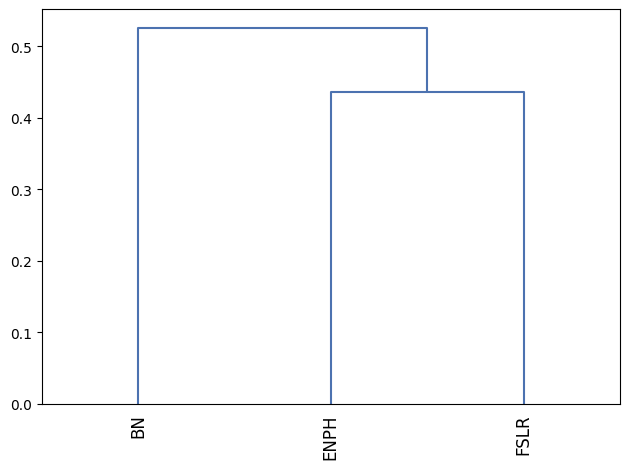

In [25]:
hrp = HRPOpt(daily_returns)
weights = hrp.optimize()
hrp.portfolio_performance(verbose=True)
print(weights)

import pypfopt.plotting as plotting
plotting.plot_dendrogram(hrp)  # to plot dendrogram

In [ ]:
cla = CLA(mu, S)
print(cla.max_sharpe())
cla.portfolio_performance(verbose=True)
plotting.plot_efficient_frontier(cla)  # to plot

# Summary

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

import universal as up
from universal import tools, algos
from universal.algos import *

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (16, 8)

In [ ]:
# Prepare data for visualizations
'''
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
company_names = ['Company 1', 'Company 2', 'Company 3']

# Box Plots

for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    data = [predicted_returns[i][model_name] for model_name in model_names]
    plt.boxplot(data, labels=model_names)
    plt.title(f'Box Plot of Predicted Returns for {company_names[i]}')
    plt.ylabel('Expected Return')
    plt.show()

# Line Plots for Actual vs. Predicted Returns
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = predicted_returns[i]

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
    plt.plot(y_test.index, predictions['Linear Regression'], label='Predicted Returns - Linear Regression', color='red')
    plt.plot(y_test.index, predictions['Random Forest'], label='Predicted Returns - Random Forest', color='green')
    plt.plot(y_test.index, predictions['XGBoost'], label='Predicted Returns - XGBoost', color='orange')
    plt.title(f'Actual vs Predicted Returns for {company_names[i]}')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

# Scatter Plots for Actual vs. Predicted Returns
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = predicted_returns[i]

    plt.figure(figsize=(14, 7))
    plt.scatter(y_test, predictions['Linear Regression'], label='Linear Regression', color='red')
    plt.scatter(y_test, predictions['Random Forest'], label='Random Forest', color='green')
    plt.scatter(y_test, predictions['XGBoost'], label='XGBoost', color='orange')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title(f'Scatter Plot of Actual vs Predicted Returns for {company_names[i]}')
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.show()
'''

In [ ]:

print("\nConfidence Intervals Matrix (95% CI):")
print(confidence_intervals_matrix)

# Prepare data for visualizations
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
company_names = ['Company 1', 'Company 2', 'Company 3']

# Plot predicted returns with confidence intervals
for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    for j in range(n_models):
        plt.errorbar(j, returns_matrix[i, j],
                     yerr=[[returns_matrix[i, j] - confidence_intervals_matrix[i, j, 0]], [confidence_intervals_matrix[i, j, 1] - returns_matrix[i, j]]],
                     fmt='o', capsize=5, label=f'{model_names[j]} Mean Return')
    plt.title(f'Returns and Confidence Intervals for {company_names[i]}')
    plt.xlabel('Model')
    plt.ylabel('Expected Return')
    plt.xticks(range(n_models), model_names)
    plt.legend()
    plt.show()

In [ ]:
import seaborn as sns

for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    for model_name in model_names:
        sns.kdeplot(predicted_returns[i][model_name], label=model_name)
    plt.title(f'Density Plot of Predicted Returns for {company_names[i]}')
    plt.xlabel('Expected Return')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [ ]:
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
company_names = ['Company 1', 'Company 2', 'Company 3']

for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    for j in range(n_models):
        plt.bar(j, returns_matrix[i, j], label=f'{model_names[j]} Mean Return')
    plt.title(f'Predicted Returns for {company_names[i]}')
    plt.xlabel('Model')
    plt.ylabel('Expected Return')
    plt.xticks(range(n_models), model_names)
    plt.legend()
    plt.show()

In [ ]:
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = train_and_predict(X_train, y_train, X_test)

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
    plt.plot(y_test.index, predictions['LinearRegression'], label='Predicted Returns - Linear Regression', color='red')
    plt.plot(y_test.index, predictions['RandomForest'], label='Predicted Returns - Random Forest', color='green')
    plt.plot(y_test.index, predictions['XGBoost'], label='Predicted Returns - XGBoost', color='orange')
    plt.title(f'Actual vs Predicted Returns for {company_names[i]}')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()